In [1]:
# usual imports

import numpy as np

import scipy.stats as sts
import pandas as pd


import sys
import pickle
from matplotlib import pyplot as plt
sys.path.append('./../packages')
data_path = "../data/"
post_path = "../data/"
from utility import uniquify, reg_log

from feat_extractor import post_extract 
from hunt import extract_scores
from scipy.integrate import trapezoid # could use other integration methods

In [2]:
# just figure plotting parameters (to have them standardized based on figure width)
from style import le_size, la_size, ti_size, majt_size, mint_size, figwidth

colormap = 'pink_r'
color_list = [u'#003f5c', u'#58508d', u'#bc5090', u'#ff6361', u'#ffa600']
#color_list = [u'#1f77b4', u'#ff7f0e', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
mfixed_labs = [r"$m_a=0.2$GeV", r"$m_a=1.0$GeV", r"$m_a=4.0$GeV"]

## Full analysis strategy and plotting

The compressed files need to be unzipped and decompressed before the notebook is compiled

In [3]:
# only this combination of data is already available
# other data can be simulated with the provided scripts
smear = 1   # 0 small uncertainty, 1 large uncertainty
mfixed = 1. # fix the mass to 0.2, 1., 4. GeV


if smear ==0:
    sigs, labsm = [0.001,0.01,0.005, 0.005 ], "small" # small uncertainty case
elif smear == 1:
    sigs, labsm = [0.001,0.05,0.01,  0.01  ], "large" # large uncertainty case

# experiment parameters
malp_min, malp_max = 0.1, 4.5
tmalp_min, tmalp_max = 0.05, 500
z_min, z_max, z_cal, l_x, l_y= 32, 82, 93, 2, 3
x_min, x_max = -l_x, l_x
y_min, y_max = -l_y, l_y

par_lab = "m_"+str(malp_min)+"_"+str(malp_max)+"_tm_"+str(tmalp_min)+"_"+str(tmalp_max)+"_"
geo_lab = "c_"+str(z_min)+"_"+str(z_max)+"_"+str(l_x)+"_"+str(l_y)
mrange = np.linspace(np.log10(malp_min), np.log10(malp_max), 200) # posterior files have 200 steps

In [4]:
# fixed values of threshold and bin width

opt_thro = 0.68
opt_thrp = 0.68

if mfixed == 0.2:
    opt_bin = 4

elif mfixed == 1.:
    opt_bin = 11 # could be put differently for small and large
elif mfixed == 4.:
    if smear:
        opt_bin = 30 # could be put differently for small and large
    elif smear ==0:
        opt_bin = 48

In [5]:
data_path = post_path
sigfile = data_path + "post_sig_8_"+labsm+"_m_"+str(mfixed)+".csv"
bkgfile = data_path + "post_bkg_13_"+labsm+".csv"


## Plotting functions (must be compiled)

We decided to leave these here for easier debugging rather than importing them from a class file

Also because these are only used in this notebook

In [6]:
# plot a single step of the matrix cleaning algorithm
def extract_lists(X, Cij, jr): # Cij will be printed later
    nlist = list(range(nobs))
    ord_list = list(np.copy(max_idx_list[iS]))
    for _ in range(len(jr)):
        ord_el = nlist.index(jr[_,iS])
        nlist.pop(ord_el)
        ord_list.pop(ord_el)
    scores = (np.sum(Cij, axis = 0))/(np.sum(Cij!= 0, axis = 0))

    Xprod = np.prod(np.exp(X[:, nlist, :]), axis = 1)
    norms = trapezoid(Xprod, mrange.reshape(1, -1))
    Xprod = Xprod/norms.reshape(-1, 1)

    return nlist, ord_list, scores, Xprod

In [7]:
# all events with their ordered labels
def plot_event_list(ax, nlist, ord_list, ymax, i, j):
    for ic in range(len(nlist)):
        truth_lab = [" (bkg)", " (sig)"][int(truth_label_list[iS,ic])]
        ax[i, j].plot(mrange, np.exp(X)[iS, nlist[ic]], color = color_list[ord_list[ic]], label = 'event {}'.format(ord_list[ic] +1) + truth_lab)
    handles, labels = ax[i,j].get_legend_handles_labels()
    ax[i, j].legend([handles[idx] for idx in np.argsort(np.array(ord_list))],[labels[idx] for idx in np.argsort(np.array(ord_list))],fontsize=le_size, loc='upper left')

In [14]:
# all events with their ordered labels
def plot_event_scores(ax, nlist, ord_list, scores, ymax, i, j):
    min_idx = np.nanargmin(scores[:, iS])
    for ic in range(len(nlist)):
        ax[i, j].plot(mrange, np.exp(X)[iS, nlist[ic]], color = color_list[ord_list[ic]])
        if nlist[ic] == min_idx:
            if scores[min_idx, iS] >= thresh:
                ax[i, j].text(-0.9, 0.85*ymax-0.05*ymax*(sts.rankdata(ord_list)-1)[ic], "score {}: {:.1e} $\geq$ {}".format(ord_list[ic]+1, scores[nlist[ic], iS], thresh), color = 'darkgreen', fontsize = le_size)
            elif scores[min_idx, iS] < thresh:
                ax[i, j].text(-0.9, 0.85*ymax-0.05*ymax*(sts.rankdata(ord_list)-1)[ic], "score {}: {:.1e} < {}".format(ord_list[ic]+1, scores[nlist[ic], iS], thresh), color = 'darkred', fontsize = le_size)

        else:
            ax[i, j].text(-0.9, 0.85*ymax-0.05*ymax*(sts.rankdata(ord_list)-1)[ic], "score {}: {:.1e}".format(ord_list[ic]+1, scores[nlist[ic], iS], thresh), color = 'black', fontsize = le_size)


In [15]:
def plot_first_score(ax, nlist, ord_list, ymax, i, j):
    for ic in range(len(nlist)):
        ax[i, j].plot(mrange, np.exp(X)[iS, nlist[ic]], color = color_list[ord_list[ic]])
        if ord_list[ic] == 0:
            ax[i, j].axvline(mrange[np.argmax(np.exp(X)[iS, nlist[ic]])], ymin = (max(np.exp(X)[iS, nlist[ic]])+ 0.8)/ymax, ymax = 0.9, color = color_list[0], linestyle = '--')
        else:
            ax[i, j].axvline(mrange[np.argmax(np.exp(X)[iS, nlist[ic]])], ymin = (max(np.exp(X)[iS, nlist[ic]])+ 0.8)/ymax, ymax = 0.9+0.06*(-nobs+ord_list[ic]+1), color = color_list[0], linestyle = '--')
            ax[i, j].hlines((0.9+0.06*(-nobs+ord_list[ic]+1))*ymax, xmin = mrange[np.argmax(np.exp(X)[iS, np.argmin(ord_list)])], xmax = mrange[np.argmax(np.exp(X)[iS, nlist[ic]])], color = color_list[0], linestyle = '--')
            ax[i, j].text(mrange[np.argmax(np.exp(X)[iS, np.argmin(ord_list)])]-0.05+(mrange[np.argmax(np.exp(X)[iS, nlist[ic]])]-mrange[np.argmax(np.exp(X)[iS, np.argmin(ord_list)])])/2, (0.915+0.06*(-nobs+ord_list[ic]+1))*ymax, r"$C_{1%i}$" %(ord_list[ic]+1), color = color_list[0], fontsize = le_size)

In [16]:
def plot_combined(ax, jr, i, j, plot_true = 0):
    nlist = list(range(nobs))
    for _ in range(len(jr)):
        nlist.remove(jr[_,iS])

    Xprod = np.prod(np.exp(X[:, nlist,:]), axis = 1)
    norms = trapezoid(Xprod, mrange.reshape(1, -1))
    Xprod = Xprod/norms.reshape(-1, 1)
    sigs_prod = np.sqrt(trapezoid((mrange**2)*Xprod, mrange.reshape(1,-1))-trapezoid(mrange*Xprod, mrange.reshape(1, -1))**2) 
    meanmass_prod = trapezoid(mrange*Xprod, mrange.reshape(1, -1))
    ax[i, j].plot(mrange, Xprod[iS], color = 'black')
    ymax = 1.2*ax[i, j].get_ylim()[1] # tolerance factor

    if plot_true:
        Xprod = np.prod(np.exp(X[:, list(range(nsig)),:]), axis = 1)
        norms = trapezoid(Xprod, mrange.reshape(1, -1))
        Xprod = Xprod/norms.reshape(-1, 1)
        sigs_prod_true = np.sqrt(trapezoid((mrange**2)*Xprod, mrange.reshape(1,-1))-trapezoid(mrange*Xprod, mrange.reshape(1, -1))**2) 
        meanmass_prod_true = trapezoid(mrange*Xprod, mrange.reshape(1, -1))
        ax[i, j].plot(mrange, Xprod[iS], color = 'grey')
        ymax = 1.2*ax[i, j].get_ylim()[1] # tolerance factor
        ax[i, j].text(-0.95, 0.725*ymax, r"$\log_{{10}}m_a=${:.2f}$\pm${:.2f}".format(meanmass_prod_true[iS], sigs_prod_true[iS]),  fontsize = le_size, color = 'grey')
    ax[i, j].text(-0.95, 0.8*ymax, r"$\log_{{10}}m_a=${:.2f}$\pm${:.2f}".format(meanmass_prod[iS], sigs_prod[iS]),  fontsize = le_size)


    return ymax

In [17]:
def plot_axis(ax, ymax, i, j):
        ax[i, j].set_ylim(0, ymax)
        ax[i, j].set_xlabel(r"$\log_{10}m_a[\text{GeV}]$", fontsize = la_size)
        ax[i, j].set_ylabel(r"$p(\log_{10}m_a[\text{GeV}])$", fontsize = la_size)
        ax[i, j].tick_params(axis = 'both', which = 'major', labelsize = majt_size)
        ax[i, j].tick_params(axis = 'both', which = 'minor', labelsize = mint_size)
        #ax[i, j].set_title('Step {}'.format(step_count), fontweight="bold")

In [18]:
def plot_wrong(X, Cij, Cij_final, jr_final):
    ncols = 3
    nrows = 1
    
    _, ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = (figwidth*1.33, 5.5), sharey = True, gridspec_kw={"hspace": 0.25}, squeeze=False)

    ymax = plot_combined(ax, jr_final, 0, 2, plot_true = 1)
    for iobs in range(nobs):
        if ymax < 1.2*np.max(np.exp(X)[iS, iobs]):
            ymax = 1.2*np.max(np.exp(X)[iS, iobs])            
    plot_axis(ax, ymax, 0, 2)
    ax[0, 2].axvline(np.log10(mfixed), color = 'grey', linestyle = '--')

    
    nlist, ord_list, scores, _ = extract_lists(X, Cij, [])
    plot_event_list(ax, nlist, ord_list, ymax, 0,0)
    plot_axis(ax, ymax, 0, 0)

    nlist, ord_list, scores, _ = extract_lists(X, Cij_final, jr_final)
    plot_event_scores(ax, nlist, ord_list, scores,ymax, 0,1)
    plot_axis(ax, ymax, 0, 1)

    ax[0, 0].set_title('Extract posteriors', fontsize=ti_size, fontweight="bold")
    ax[0, 1].set_title('Keep compatible events', fontsize=ti_size, fontweight="bold")
    ax[0, 2].set_title('Combine posteriors', fontsize=ti_size, fontweight="bold")

## Plot true compatible events

In [19]:
nbkg = 2 # how many bkg events in the sample
nsig = 3 # how many sig events in the sample
nobs = nbkg+nsig


feats = post_extract(bkgfile)
x0= feats.extract_post(nbkg)
del feats

feats = post_extract(sigfile)
x1= feats.extract_post(nsig)
del feats

x0 = x0.reshape(10000,nbkg,200)
x1 = x1.reshape(10000,nsig,200)
X = np.hstack((x1,x0)) # first sig and then bkg

X contains the full posteriors -> used to derive the combined posterior

Compatibility scores are already exported externally

In [20]:
thresh = opt_thrp # use the optimal threshold from earlier (or fixed it by hand if you prefer)

# these are masks used to "remove" the events with the cleaning strategy
onesm = np.ones([nobs, nobs])
masks = []
for iobs in range(nobs):
    mask = np.copy(onesm)
    mask[:,iobs]=0
    mask[iobs,:]=0
    masks.append(mask)

In [21]:
# this performs a single cleaning step on the matrix Cij
# return "cleaned" matrix and index of removed event
def single_step(Cij):
    Cij2 = np.copy(Cij)
    scores = (np.sum(Cij2,axis=0))/(np.sum(Cij2!=0,axis=0))
    scores[np.isnan(scores)]=np.inf
    jr = np.argmin(scores,axis=0)
    maskstot = np.array(masks)[jr]
    maskstot[np.choose(jr, scores)>thresh]=onesm
    maskstot = np.transpose(maskstot)
    Cij2= Cij2*maskstot
    return Cij2, jr

In [22]:
labpost = "_post_" # just to say load the EPO and not the ECO scores, should not be changed
CijSS = np.load("../performances/Cijs/CijSS"+labpost+str(mfixed)+"_"+labsm+".npy")
CijBS = np.load("../performances/Cijs/CijBS"+labpost+str(mfixed)+"_"+labsm+".npy")
CijBB = np.load("../performances/Cijs/CijBB"+labpost+labsm+".npy")

In [23]:
# we stack the Cij together to have it vectorialized
Cij3d = np.zeros([nobs, nobs, 10000])
for i in range (nobs):
    for j in range(i+1, nobs):
        if ((i < nsig) and (j<nsig)):
            Cij = CijSS
            Cij3d[i, j, :] = Cij[(Cij[:,0]==i)*(Cij[:,1]==j)][:,2:]
            Cij3d[j, i, :] = Cij3d[i, j, :]
        elif ((i < nsig) and (j>=nsig)):
            Cij = CijBS
            Cij3d[i, j, :] = Cij[(Cij[:,0]==j-nsig)*(Cij[:,1]==i)][:,2:]
            Cij3d[j, i, :] = Cij3d[i, j, :]   
        elif ((i >= nsig) and (j>=nsig)):
            Cij = CijBB
            Cij3d[i, j, :] = Cij[(Cij[:,0]==i-nsig)*(Cij[:,1]==j-nsig)][:,2:]
            Cij3d[j, i, :] = Cij3d[i, j, :]
del Cij
scores_final = extract_scores(CijSS, CijBS, CijBB, nbkg, nsig, opt_thrp) # these are ordered as first the signal scores and then the bkg scores

/home/alessandro/Desktop/Gitlab/github/param_hunt/notebooks/./../packages/hunt.py:22: RuntimeWarning: invalid value encountered in divide
  scores = (np.sum(Cij,axis=0))/(np.sum(Cij!=0,axis=0))
/home/alessandro/Desktop/Gitlab/github/param_hunt/notebooks/./../packages/hunt.py:200: RuntimeWarning: invalid value encountered in divide
  scores = (np.sum(Cij_clean,axis=0))/(np.sum(Cij_clean!=0,axis=0))


In [24]:
# change order of events so that they are ordered by predicted mass
truth_label = []
for n in range(nsig):
    truth_label.append(1)
for n in range(nbkg):
    truth_label.append(0)
truth_label = np.asarray(truth_label)
truth_label_list = truth_label*np.ones(shape=(10000, nobs))

max_idx_list = sts.rankdata(np.argmax(X, axis=2),axis=1, method='ordinal')-1

In [25]:
# check which sample events are retained in the end (first we have nbkg events, then nsig events)
# it should be T T T F F for the case of rejected bkg and accepted signal
iS = 2 
print((scores_final>0)[:,iS])
print((scores_final)[:,iS])
print(truth_label_list[iS])

print("\nOnce reordered:")
print((scores_final>0)[max_idx_list[iS],iS])
print((scores_final)[max_idx_list[iS],iS])
print(truth_label_list[iS, max_idx_list[iS]])

[ True  True  True False False]
[0.92742026 0.92213163 0.91222379 0.         0.        ]
[1. 1. 1. 0. 0.]

Once reordered:
[False  True  True  True False]
[0.         0.92213163 0.91222379 0.92742026 0.        ]
[0. 1. 1. 1. 0.]


In [26]:
# these are put here by hand, works only for this scenario
Cij2, jr2_temp = single_step(Cij3d)
Cij3, jr3_temp = single_step(Cij2)
jr3= np.vstack((jr2_temp,jr3_temp))
jr2 = jr2_temp.reshape(1, -1)

/tmp/ipykernel_36241/4105806045.py:5: RuntimeWarning: invalid value encountered in divide
  scores = (np.sum(Cij2,axis=0))/(np.sum(Cij2!=0,axis=0))


In [27]:
sigok = np.prod(scores_final[:nsig,:],axis=0)>0
bkgok = np.sum(scores_final[nsig:,:],axis=0)==0

In [28]:
# events where both the signal and bkg are correctly identified
[iS for iS, el in enumerate(sigok*bkgok) if ((el >0) and (iS < 20))]

[2, 7, 8, 9, 10, 11, 14, 16, 17, 18, 19]

In [29]:
def plot_correct(X, Cij, Cij2, Cij3, jr2, jr3):
    ncols = 3
    nrows = 2
    
    _, ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = (figwidth*1.33, 12), sharey = True, gridspec_kw={"hspace": 0.25})

    ymax = plot_combined(ax, jr3, 1, 2)
    for iobs in range(nobs):
        if ymax < np.max(np.exp(X)[iS, iobs]):
            ymax = np.max(np.exp(X)[iS, iobs])
            
    plot_axis(ax, ymax, 1, 2)
    ax[1, 2].axvline(np.log10(mfixed), color = 'grey', linestyle = '--')

    
    nlist, ord_list, scores, _ = extract_lists(X, Cij, [])
    plot_event_list(ax, nlist, ord_list, ymax, 0,0)
    plot_axis(ax, ymax, 0, 0)

    plot_first_score(ax, nlist, ord_list, ymax, 0, 1)
    plot_axis(ax, ymax, 0, 1)

    plot_event_scores(ax, nlist, ord_list, scores,ymax, 0,2)
    plot_axis(ax, ymax, 0, 2)

    nlist, ord_list, scores, _ = extract_lists(X, Cij2, jr2)
    plot_event_scores(ax, nlist, ord_list, scores,ymax, 1,0)
    plot_axis(ax, ymax, 1, 0)

    nlist, ord_list, scores, _ = extract_lists(X, Cij3, jr3)
    plot_event_scores(ax, nlist, ord_list, scores,ymax, 1,1)
    plot_axis(ax, ymax, 1, 1)

    ax[0, 0].set_title('Extract posteriors', fontsize=ti_size, fontweight="bold")
    ax[0, 1].set_title('Compute compatibility scores', fontsize=ti_size, fontweight="bold")
    ax[0, 2].set_title('Discard 1st incompatible event', fontsize=ti_size, fontweight="bold")
    ax[1, 0].set_title('Discard 2nd incompatible event', fontsize=ti_size, fontweight="bold")
    ax[1, 1].set_title('Keep compatible events', fontsize=ti_size, fontweight="bold")
    ax[1, 2].set_title('Combine posteriors', fontsize=ti_size, fontweight="bold")

/tmp/ipykernel_36241/1520926847.py:13: RuntimeWarning: invalid value encountered in divide
  Xprod = Xprod/norms.reshape(-1, 1)
/tmp/ipykernel_36241/1520926847.py:9: RuntimeWarning: invalid value encountered in divide
  scores = (np.sum(Cij, axis = 0))/(np.sum(Cij!= 0, axis = 0))


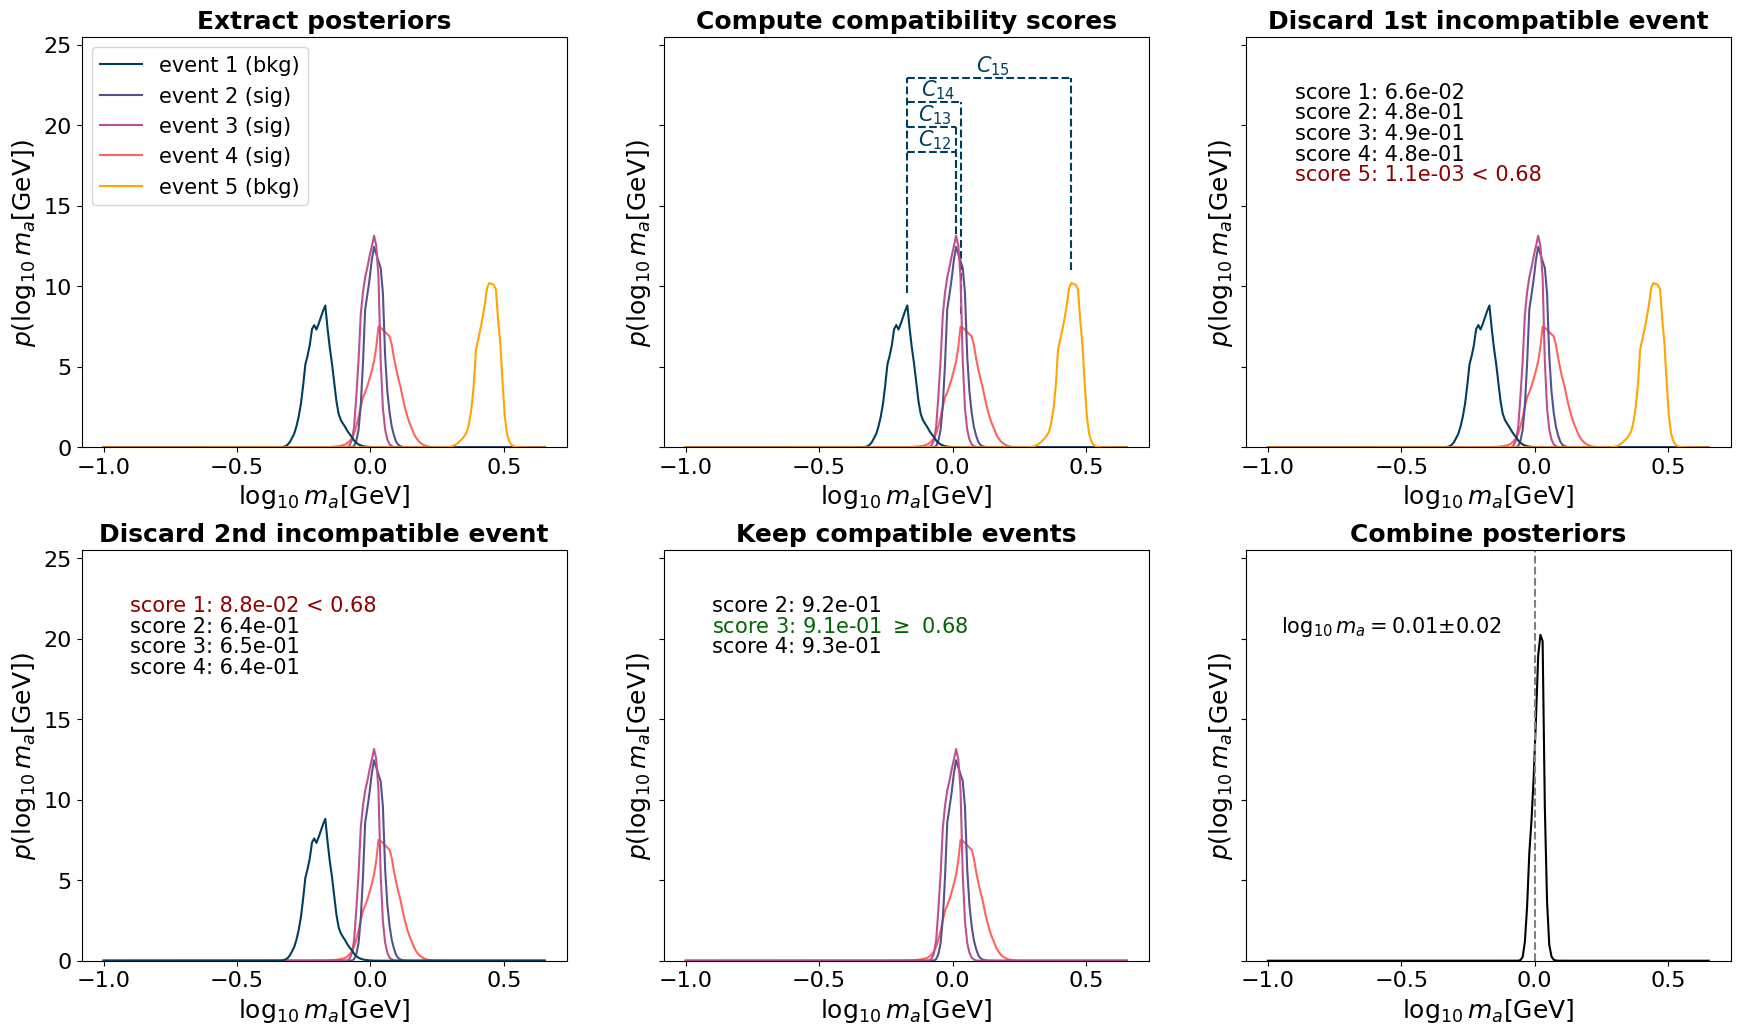

In [30]:
plot_correct(X, Cij3d, Cij2, Cij3, jr2, jr3)
#plt.savefig("../figures/figs_examples_"+str(iS)+".pdf",bbox_inches='tight')
plt.show()

### Coverage

We can check the coverage for multiple events (this is different from the coverage of the posteriors of single events)

In [31]:
# only this combination of data is already available
# other data can be simulated with the provided scripts
smear = 1   # 0 small uncertainty, 1 large uncertainty
mfixed = 1. # fix the mass to 0.2, 1., 4. GeV


if smear ==0:
    sigs, labsm = [0.001,0.01,0.005, 0.005 ], "small" # small smearing case
elif smear == 1:
    sigs, labsm = [0.001,0.05,0.01,  0.01  ], "large"

# experiment parameters
malp_min, malp_max = 0.1, 4.5
tmalp_min, tmalp_max = 0.05, 500
z_min, z_max, z_cal, l_x, l_y= 32, 82, 93, 2, 3
x_min, x_max = -l_x, l_x
y_min, y_max = -l_y, l_y

par_lab = "m_"+str(malp_min)+"_"+str(malp_max)+"_tm_"+str(tmalp_min)+"_"+str(tmalp_max)+"_"
geo_lab = "c_"+str(z_min)+"_"+str(z_max)+"_"+str(l_x)+"_"+str(l_y)
mrange = np.linspace(np.log10(malp_min), np.log10(malp_max), 200) # posterior files have 200 steps

In [32]:
nsig = 8
sigfile = post_path+  "post_sig_8_"+labsm+"_m_"+str(mfixed)+".csv"

In [33]:
feats = post_extract(sigfile)
X= feats.extract_post(nsig)
X = X.reshape(10000,nsig,200)
del feats

In [34]:
# calculate the product of posteriors (+ normalization) and the inferred mass with uncertainty
def post_prod(x):
    xprod =  np.prod(np.exp(x),axis=1)
    norms = trapezoid(xprod, mrange.reshape(1,-1))
    xprod = xprod/norms.reshape(-1,1)
    return xprod

def mass_sig(X): 
    meanmass= (trapezoid(mrange*X, mrange.reshape(1,-1)))
    sigs = (np.sqrt(trapezoid((mrange**2)*X, mrange.reshape(1,-1))-trapezoid(mrange*X, mrange.reshape(1,-1))**2))
    return meanmass, sigs

In [35]:
# check the scaling of the uncertainty
perf_scal = []
for iobs in range(1,nsig+1):
    X0 = post_prod(X[:,:iobs,:])
    X0 = np.array(X0)
    mass, sigs = mass_sig(X0)
    perf_scal.append([iobs, np.mean(sigs), np.std(sigs), np.std(mass)])
perf_scal = np.array(perf_scal)

In [36]:
from scipy.optimize import curve_fit

We exclude the first point as we combine at least two events

In [37]:
def sqrt_scaling(x, a):
    return a/np.sqrt(x)

meanval, _ = curve_fit(sqrt_scaling, perf_scal[1:,0], perf_scal[1:,1])

In [38]:
def chi2(yi, fi, sigma):
    return np.sum((yi-fi)**2/sigma**2)

In [39]:
chi2(perf_scal[1:,1],sqrt_scaling(perf_scal[1:,0], meanval), perf_scal[1:,2])

0.34748762179425086

In [40]:
for tryval in np.linspace(0.03, 0.05, 21):
    print(tryval, chi2(perf_scal[1:,1],sqrt_scaling(perf_scal[1:,0], tryval), perf_scal[1:,2]))

0.03 9.198384223967777
0.031 7.806024927649308
0.032 6.529499244741092
0.033 5.368807175243128
0.034 4.323948719155413
0.035 3.394923876477952
0.036000000000000004 2.581732647210739
0.037 1.8843750313537821
0.038 1.3028510289070714
0.039 0.8371606398706118
0.04 0.4873038642444035
0.041 0.25328070202844544
0.042 0.13509115322273876
0.043000000000000003 0.13273521782728298
0.044000000000000004 0.24621289584207795
0.045 0.4755241872671222
0.046 0.8206690921024191
0.047 1.2816476103479677
0.048 1.8584597420037645
0.049 2.5511054870698158
0.05 3.359584845546114


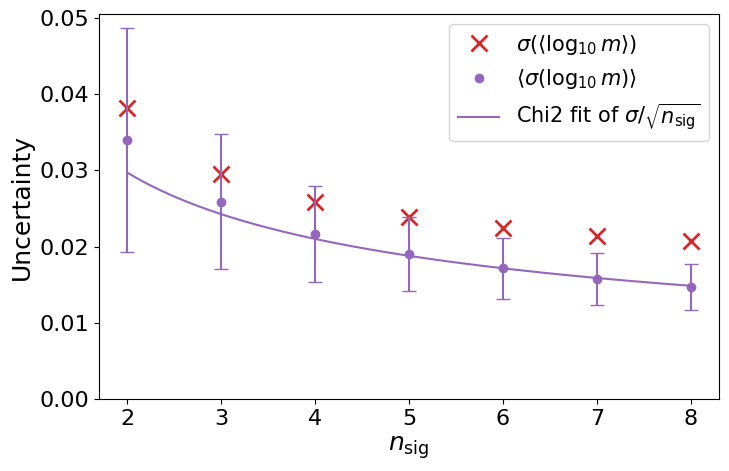

In [41]:
xlin_obs = np.linspace(2,8,200)
fig,ax = plt.subplots(figsize=(figwidth/2,5))
ax.plot(perf_scal[1:,0], perf_scal[1:,3], label = r"$\sigma(\langle \log_{10} m \rangle)$", marker ='x', markeredgewidth=2, markersize=12, linestyle='', color='C3')
ax.errorbar(perf_scal[1:,0], perf_scal[1:,1], perf_scal[1:,2], ls='', capsize=5, capthick=1, color='C4')
ax.plot(perf_scal[1:,0], perf_scal[1:,1],  marker='o', label = r"$\langle\sigma(\log_{10} m)\rangle$", linestyle='', color='C4')
ax.plot(xlin_obs, sqrt_scaling(xlin_obs, 0.042), color='C4', linewidth=1.5, label='Chi2 fit of $\sigma/\sqrt{n_\\text{sig}}$')


plt.legend(fontsize=le_size)
ax.tick_params(axis='both', which='major', labelsize=majt_size)
ax.tick_params(axis='both', which='minor', labelsize=mint_size)
plt.xlabel("$n_\\text{sig}$", fontsize=la_size)
plt.ylabel("Uncertainty", fontsize=la_size)
plt.ylim(0,ax.get_ylim()[1])
# plt.savefig("../figures/Nscaling_log.pdf", bbox_inches='tight')
plt.show()

In [42]:
# let's check the coverage
ibin = np.digitize(np.log10(mfixed), mrange)
def comp_clevel(X):
    clevel = []
    for iS in range(len(X)):
        posts= X[iS]
        clevel.append(trapezoid(posts[posts>(posts[ibin-1]+posts[ibin])/2], mrange.reshape(-1,1)[posts>(posts[ibin-1]+posts[ibin])/2].T))
    clevel = np.array(clevel)
    return clevel

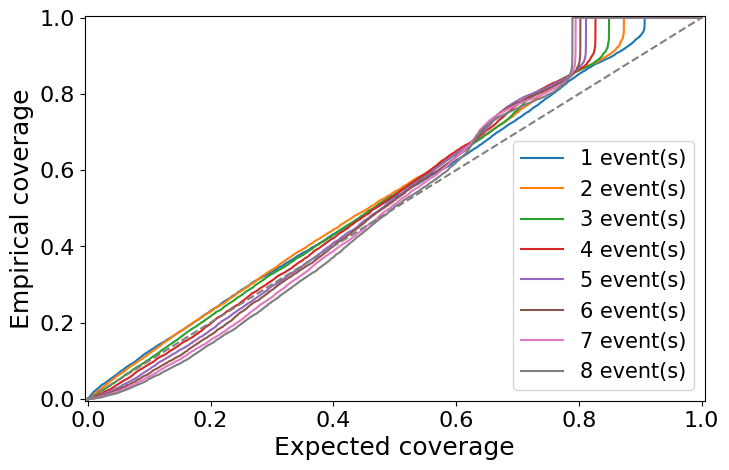

In [43]:
fig,ax = plt.subplots(figsize=(figwidth/2,5))
for nsig in range(1, 9):
    clevel = comp_clevel(post_prod(X[:,:nsig,:]))
    ax.plot(np.linspace(0,1, len(clevel)), np.sort(1-clevel.flatten()), linewidth=1.5, label=str(nsig)+" event(s)")



plt.plot(np.linspace(0,1, 10000), np.linspace(0,1, 10000), color='grey', linestyle='--')
plt.xlim(-0.005, 1.005)
plt.ylim(-0.005, 1.005)
plt.legend(fontsize=le_size)
ax.tick_params(axis='both', which='major', labelsize=majt_size)
ax.tick_params(axis='both', which='minor', labelsize=mint_size)
plt.xlabel("Expected coverage", fontsize=la_size)
plt.ylabel("Empirical coverage", fontsize=la_size)
#plt.savefig("figures/coverage_nsig_8.pdf", bbox_inches='tight')
plt.show()


In [44]:
# check the scaling of the uncertainty
perf_scal = []
for iobs in range(1,nsig+1):
    X0 = post_prod(X[:,:iobs,:])
    X0 = np.array(X0)
    mass, sigs = mass_sig(X0)
    perf_scal.append([iobs, np.mean(sigs*np.log(10)*10**mass),
                            np.std(sigs*np.log(10)*10**mass),
                            np.std(10**mass)])
perf_scal = np.array(perf_scal)

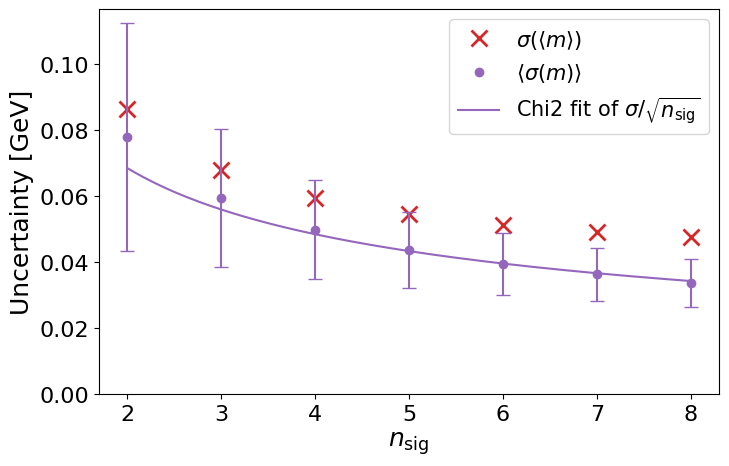

In [45]:
xlin_obs = np.linspace(2,8,200)
fig,ax = plt.subplots(figsize=(figwidth/2,5))
ax.plot(perf_scal[1:,0], perf_scal[1:,3], label = r"$\sigma(\langle m \rangle)$", marker ='x', markeredgewidth=2, markersize=12, linestyle='', color='C3')
ax.errorbar(perf_scal[1:,0], perf_scal[1:,1], perf_scal[1:,2], ls='', capsize=5, capthick=1, color='C4')
ax.plot(perf_scal[1:,0], perf_scal[1:,1],  marker='o', label = r"$\langle\sigma( m)\rangle$", linestyle='', color='C4')
ax.plot(xlin_obs, sqrt_scaling(xlin_obs, 0.042*np.log(10)), color='C4', linewidth=1.5, label='Chi2 fit of $\sigma/\sqrt{n_\\text{sig}}$')


plt.legend(fontsize=le_size)
ax.tick_params(axis='both', which='major', labelsize=majt_size)
ax.tick_params(axis='both', which='minor', labelsize=mint_size)
plt.xlabel("$n_\\text{sig}$", fontsize=la_size)
plt.ylabel("Uncertainty [GeV]", fontsize=la_size)
plt.ylim(0,ax.get_ylim()[1])
plt.savefig("../figures/Nscaling.pdf", bbox_inches='tight')
plt.show()

## Accepting bkg and discarding signal

### accepting bkg

In [46]:
nbkg = 2 # how many bkg events in the sample
nsig = 3 # how many sig events in the sample
nobs = nbkg+nsig


feats = post_extract(bkgfile)
x0= feats.extract_post(nbkg)
del feats

feats = post_extract(sigfile)
x1= feats.extract_post(nsig)
del feats


x0 = x0.reshape(10000,nbkg,200)
x1 = x1.reshape(10000,nsig,200)
X = np.hstack((x1,x0)) # first sig and then bkg

X contains the full posteriors -> used to derive the combined posterior

In [47]:
thresh = opt_thrp # use the optimal threshold from earlier (or fixed it by hand if you rpefer)

# these are masks used to "remove" the events with the cleaning strategy
onesm = np.ones([nobs, nobs])
masks = []
for iobs in range(nobs):
    mask = np.copy(onesm)
    mask[:,iobs]=0
    mask[iobs,:]=0
    masks.append(mask)

In [48]:
# this performs a single cleaning step on the matrix Cij
# return "cleaned" matrix and index of removed event
def single_step(Cij):
    Cij2 = np.copy(Cij)
    scores = (np.sum(Cij2,axis=0))/(np.sum(Cij2!=0,axis=0))
    scores[np.isnan(scores)]=np.inf
    jr = np.argmin(scores,axis=0)
    maskstot = np.array(masks)[jr]
    maskstot[np.choose(jr, scores)>thresh]=onesm
    maskstot = np.transpose(maskstot)
    Cij2= Cij2*maskstot
    return Cij2, jr

In [49]:
labpost = "_post_"
CijSS = np.load("../performances/Cijs/CijSS"+labpost+str(mfixed)+"_"+labsm+".npy")
CijBS = np.load("../performances/Cijs/CijBS"+labpost+str(mfixed)+"_"+labsm+".npy")
CijBB = np.load("../performances/Cijs/CijBB"+labpost+labsm+".npy")

In [50]:
# we stack the Cij to vectorialize
Cij3d = np.zeros([nobs, nobs, 10000])
for i in range (nobs):
    for j in range(i+1, nobs):
        if ((i < nsig) and (j<nsig)):
            Cij = CijSS
            Cij3d[i, j, :] = Cij[(Cij[:,0]==i)*(Cij[:,1]==j)][:,2:]
            Cij3d[j, i, :] = Cij3d[i, j, :]
        elif ((i < nsig) and (j>=nsig)):
            Cij = CijBS
            Cij3d[i, j, :] = Cij[(Cij[:,0]==j-nsig)*(Cij[:,1]==i)][:,2:]
            Cij3d[j, i, :] = Cij3d[i, j, :]   
        elif ((i >= nsig) and (j>=nsig)):
            Cij = CijBB

            Cij3d[i, j, :] = Cij[(Cij[:,0]==i-nsig)*(Cij[:,1]==j-nsig)][:,2:]
            Cij3d[j, i, :] = Cij3d[i, j, :]
del Cij

I want to select events where the compatibility is not trivial

In [51]:
scores_0 = extract_scores(CijSS, CijBS, CijBB, nbkg, nsig, 0) 
scores_final = extract_scores(CijSS, CijBS, CijBB, nbkg, nsig, opt_thrp) 

/home/alessandro/Desktop/Gitlab/github/param_hunt/notebooks/./../packages/hunt.py:22: RuntimeWarning: invalid value encountered in divide
  scores = (np.sum(Cij,axis=0))/(np.sum(Cij!=0,axis=0))
/home/alessandro/Desktop/Gitlab/github/param_hunt/notebooks/./../packages/hunt.py:200: RuntimeWarning: invalid value encountered in divide
  scores = (np.sum(Cij_clean,axis=0))/(np.sum(Cij_clean!=0,axis=0))


In [52]:
# change order of events
truth_label = []
for n in range(nsig):
    truth_label.append(1)
for n in range(nbkg):
    truth_label.append(0)
truth_label = np.asarray(truth_label)
truth_label_list = truth_label*np.ones(shape=(10000, nobs))

max_idx_list = sts.rankdata(np.argmax(X, axis=2),axis=1, method='ordinal')-1

In [53]:
Xprod_true = np.prod(np.exp(X[:, list(range(nsig)),:]), axis = 1)
norms = trapezoid(Xprod_true, mrange.reshape(1, -1))
Xprod_true = Xprod_true/norms.reshape(-1, 1)

In [54]:
sigok = np.prod(scores_final[:nsig,:],axis=0)>0   # all sig events accepted
bkgok = np.sum(scores_final[nsig:,:],axis=0)==0   # all bkg events rejected
bkg_acc = np.prod(scores_final[nsig:,:],axis=0)>0 # all bkg events accepted

In [55]:
for iS, el in enumerate(np.prod(scores_0>0.25,axis=0)*sigok*bkg_acc):
    if (el >0.2) and (iS<500): # el 0.2 to have them at least a bit compatible
        print(iS, el, scores_final[:,iS])

15 1 [0.88280673 0.8132066  0.87534359 0.77190602 0.85805809]
69 1 [0.75864115 0.84532069 0.83834301 0.86693209 0.82050309]
175 1 [0.77245286 0.83121487 0.83530498 0.69913861 0.83383924]
176 1 [0.86292902 0.84062192 0.87861854 0.83692953 0.87464839]
292 1 [0.88694967 0.88328841 0.91832611 0.89419876 0.89676359]
342 1 [0.77181725 0.84139869 0.88456953 0.739608   0.83776838]
345 1 [0.88893148 0.80963643 0.87360953 0.8923229  0.75832441]
418 1 [0.91394347 0.85744838 0.87021245 0.84311952 0.87216274]
449 1 [0.9193226  0.87504637 0.90751117 0.90429364 0.88639659]


In [56]:
iS = 176 # select a sample
print((scores_final>0)[:,iS])
print((scores_final)[:,iS])
print(truth_label_list[iS])

[ True  True  True  True  True]
[0.86292902 0.84062192 0.87861854 0.83692953 0.87464839]
[1. 1. 1. 0. 0.]


/tmp/ipykernel_36241/3094044360.py:8: RuntimeWarning: invalid value encountered in divide
  Xprod = Xprod/norms.reshape(-1, 1)
/tmp/ipykernel_36241/1520926847.py:13: RuntimeWarning: invalid value encountered in divide
  Xprod = Xprod/norms.reshape(-1, 1)


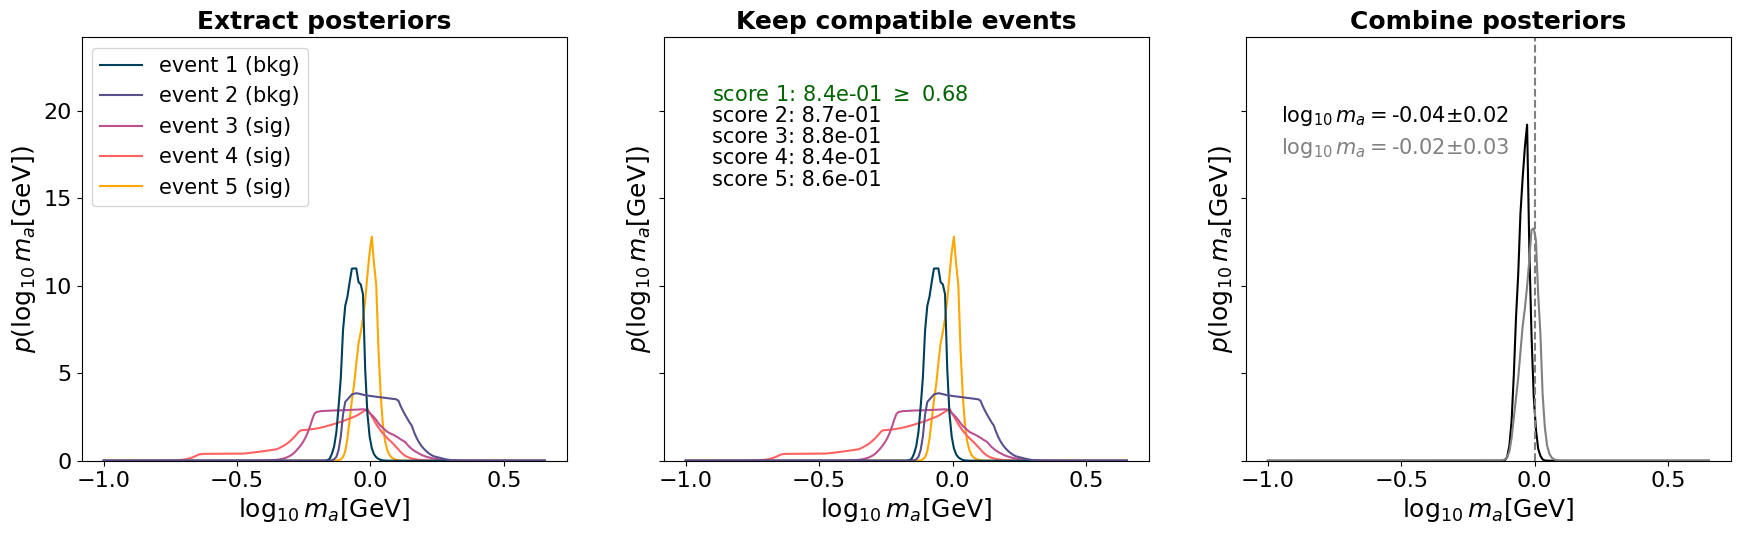

In [57]:
plot_wrong(X, Cij3d, Cij3d, [])
# plt.savefig("../figures/figs_examples_"+str(iS)+".pdf",bbox_inches='tight')

##### Coverage and sigma distribution when accepting bkg events

The next part is admittedly for the specific case of 3 sig and 2 bkg events where the sig is ok 

In [58]:
mrange = np.linspace(np.log10(malp_min), np.log10(malp_max), 200)

id_sig = np.sum((scores_final)[:nsig]>0,axis=0) # how many signal events accepted
id_bkg = np.sum((scores_final)[nsig:]>0,axis=0) # how many bkg events accepted

In [59]:
def post_prod(x):
    xprod =  np.prod(np.exp(x),axis=1)
    norms = trapezoid(xprod, mrange.reshape(1,-1))
    xprod = xprod/norms.reshape(-1,1)
    return xprod

In [60]:
range_obs = list(range(nobs))

In [61]:
# could be automated, but for now fine
X0 = post_prod(X[(id_bkg==0)*(id_sig==nsig),:nsig,:])
X0 = np.array(X0)

In [62]:
X1_list = []
for ibkg in range(nsig, nbkg+nsig):
    range_temp = range_obs.copy()
    range_temp.remove(ibkg)
    X1_temp = post_prod(X[(scores_final[ibkg]==0)*(id_bkg==1)*(id_sig==nsig)][:,range_temp,:])
    X1_list.append(np.array(X1_temp))
    print(range_temp)
X1 = np.vstack((X1_list))


[0, 1, 2, 4]
[0, 1, 2, 3]


more intermediate steps if we want other cases

In [63]:
X2 = post_prod(X[(id_bkg==nbkg)*(id_sig==nsig),:,:])
X2 = np.array(X2)

In [64]:
def mass_sig(X): 
    meanmass= (trapezoid(mrange*X, mrange.reshape(1,-1)))
    sigs = (np.sqrt(trapezoid((mrange**2)*X, mrange.reshape(1,-1))-trapezoid(mrange*X, mrange.reshape(1,-1))**2))
    return meanmass, sigs

In [65]:
meanmass0, sigs0 = mass_sig(X0)
meanmass1, sigs1 = mass_sig(X1)
meanmass2, sigs2 = mass_sig(X2)

In [66]:
ibin = np.digitize(np.log10(mfixed), mrange)
def comp_clevel(X):
    clevel = []
    for iS in range(len(X)):
        posts= X[iS]
        clevel.append(trapezoid(posts[posts>(posts[ibin-1]+posts[ibin])/2], mrange.reshape(-1,1)[posts>(posts[ibin-1]+posts[ibin])/2].T))
    clevel = np.array(clevel)
    return clevel

In [67]:
clevel0 = comp_clevel(X0)
clevel1 = comp_clevel(X1)
clevel2 = comp_clevel(X2)

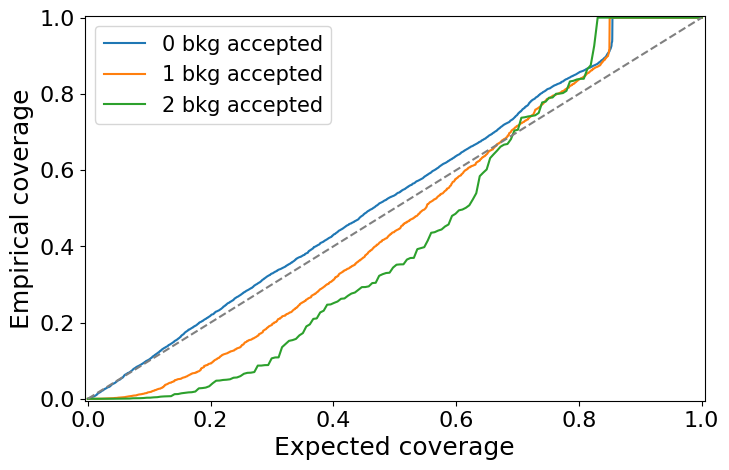

In [68]:
fig,ax = plt.subplots(figsize=(figwidth/2,5))
ax.plot(np.linspace(0,1, len(clevel0)), np.sort(1-clevel0.flatten()), linewidth=1.5, label="0 bkg accepted")
ax.plot(np.linspace(0,1, len(clevel1)), np.sort(1-clevel1.flatten()), linewidth=1.5, label="1 bkg accepted")
ax.plot(np.linspace(0,1, len(clevel2)), np.sort(1-clevel2.flatten()), linewidth=1.5, label="2 bkg accepted")


plt.plot(np.linspace(0,1, 10000), np.linspace(0,1, 10000), color='grey', linestyle='--')
plt.xlim(-0.005, 1.005)
plt.ylim(-0.005, 1.005)
plt.legend(fontsize=le_size)
ax.tick_params(axis='both', which='major', labelsize=majt_size)
ax.tick_params(axis='both', which='minor', labelsize=mint_size)
plt.xlabel("Expected coverage", fontsize=la_size)
plt.ylabel("Empirical coverage", fontsize=la_size)
# plt.savefig("figures/coverage_bkg.pdf", bbox_inches='tight')
plt.show()

### rejecting signal

In [69]:
nbkg = 1 # how many bkg events in the sample
nsig = 4 # how many sig events in the sample
nobs = nbkg+nsig


feats = post_extract(bkgfile)
x0= feats.extract_post(nbkg)
del feats

feats = post_extract(sigfile)
x1= feats.extract_post(nsig)
del feats

x0 = x0.reshape(10000,nbkg,200)
x1 = x1.reshape(10000,nsig,200)
X = np.hstack((x1,x0)) # first sig and then bkg

X contains the full posteriors -> used to derive the combined posterior

In [70]:
thresh = opt_thrp # use the optimal threshold from earlier (or fixed it by hand if you rpefer)

# these are masks used to "remove" the events with the cleaning strategy
onesm = np.ones([nobs, nobs])
masks = []
for iobs in range(nobs):
    mask = np.copy(onesm)
    mask[:,iobs]=0
    mask[iobs,:]=0
    masks.append(mask)

In [71]:
# this performs a single cleaning step on the matrix Cij
# return "cleaned" matrix and index of removed event
def single_step(Cij):
    Cij2 = np.copy(Cij)
    scores = (np.sum(Cij2,axis=0))/(np.sum(Cij2!=0,axis=0))
    scores[np.isnan(scores)]=np.inf
    jr = np.argmin(scores,axis=0)
    maskstot = np.array(masks)[jr]
    maskstot[np.choose(jr, scores)>thresh]=onesm
    maskstot = np.transpose(maskstot)
    Cij2= Cij2*maskstot
    return Cij2, jr

In [72]:
labpost = "_post_"
CijSS = np.load("../performances/Cijs/CijSS"+labpost+str(mfixed)+"_"+labsm+".npy")
CijBS = np.load("../performances/Cijs/CijBS"+labpost+str(mfixed)+"_"+labsm+".npy")
CijBB = np.load("../performances/Cijs/CijBB"+labpost+labsm+".npy")

In [73]:
# we stack them to vectorialize
Cij3d = np.zeros([nobs, nobs, 10000])
for i in range (nobs):
    for j in range(i+1, nobs):
        if ((i < nsig) and (j<nsig)):
            Cij = CijSS
            Cij3d[i, j, :] = Cij[(Cij[:,0]==i)*(Cij[:,1]==j)][:,2:]
            Cij3d[j, i, :] = Cij3d[i, j, :]
        elif ((i < nsig) and (j>=nsig)):
            Cij = CijBS
            Cij3d[i, j, :] = Cij[(Cij[:,0]==j-nsig)*(Cij[:,1]==i)][:,2:]
            Cij3d[j, i, :] = Cij3d[i, j, :]   
        elif ((i >= nsig) and (j>=nsig)):
            Cij = CijBB
            Cij3d[i, j, :] = Cij[(Cij[:,0]==i-nsig)*(Cij[:,1]==j-nsig)][:,2:]
            Cij3d[j, i, :] = Cij3d[i, j, :]
del Cij

I want to select events where the compatibility is not trivial

In [74]:
scores_0 = extract_scores(CijSS, CijBS, CijBB, nbkg, nsig, 0) 
scores_final = extract_scores(CijSS, CijBS, CijBB, nbkg, nsig, opt_thrp) 

/home/alessandro/Desktop/Gitlab/github/param_hunt/notebooks/./../packages/hunt.py:22: RuntimeWarning: invalid value encountered in divide
  scores = (np.sum(Cij,axis=0))/(np.sum(Cij!=0,axis=0))
/home/alessandro/Desktop/Gitlab/github/param_hunt/notebooks/./../packages/hunt.py:200: RuntimeWarning: invalid value encountered in divide
  scores = (np.sum(Cij_clean,axis=0))/(np.sum(Cij_clean!=0,axis=0))


In [75]:
# change order of events
truth_label = []
for n in range(nsig):
    truth_label.append(1)
for n in range(nbkg):
    truth_label.append(0)
truth_label = np.asarray(truth_label)
truth_label_list = truth_label*np.ones(shape=(10000, nobs))

max_idx_list = sts.rankdata(np.argmax(X, axis=2),axis=1, method='ordinal')-1

In [76]:
Xprod_true = np.prod(np.exp(X[:, list(range(nsig)),:]), axis = 1)
norms = trapezoid(Xprod_true, mrange.reshape(1, -1))
Xprod_true = Xprod_true/norms.reshape(-1, 1)

In [77]:
sigok = np.prod(scores_final[:nsig,:],axis=0)>0      # all sig events accepted
bkgok = np.sum(scores_final[nsig:,:],axis=0)==0      # all bkg events rejected
rej_sig = np.sum(scores_final[:nsig,:] == 0, axis=0) # number of rejected signal events

In [78]:
for iS, el in enumerate(np.prod(scores_0>0.15,axis=0)*bkgok*(rej_sig==2)):# 2 rejected signal events
    if (el >0.2) and (iS<10000):
        print(iS, el, scores_final[:,iS])

1179 1 [0.         0.93699598 0.93699598 0.         0.        ]
1418 1 [0.         0.91662633 0.91662633 0.         0.        ]
1554 1 [0.95378041 0.         0.         0.95378041 0.        ]
1775 1 [0.93093157 0.         0.         0.93093157 0.        ]
1782 1 [0.89871466 0.         0.         0.89871466 0.        ]
2044 1 [0.94478929 0.         0.94478929 0.         0.        ]
3075 1 [0.         0.92786568 0.         0.92786568 0.        ]
3766 1 [0.         0.88911927 0.88911927 0.         0.        ]
3990 1 [0.90596694 0.90596694 0.         0.         0.        ]
4093 1 [0.         0.93033934 0.93033934 0.         0.        ]
5822 1 [0.         0.         0.88317907 0.88317907 0.        ]
5909 1 [0.         0.92045903 0.         0.92045903 0.        ]
6437 1 [0.94692498 0.         0.94692498 0.         0.        ]
6580 1 [0.97097331 0.         0.97097331 0.         0.        ]
6705 1 [0.9245044 0.9245044 0.        0.        0.       ]
7581 1 [0.94515067 0.         0.         0.94

In [79]:
# these are put here by hand
Cij2, jr2_temp = single_step(Cij3d)
Cij3, jr3_temp = single_step(Cij2)
Cij4, jr4_temp = single_step(Cij3)

jr4= np.vstack((jr2_temp,jr3_temp,jr4_temp))
jr3= np.vstack((jr2_temp,jr3_temp))
jr2 = jr2_temp.reshape(1, -1)

/tmp/ipykernel_36241/4105806045.py:5: RuntimeWarning: invalid value encountered in divide
  scores = (np.sum(Cij2,axis=0))/(np.sum(Cij2!=0,axis=0))


In [80]:
# check which sample events are retained in the end (first we have nbkg events, then nsig events)
# it should be F F T T T for the case of rejected bkg and accepted signal
iS = 1105 # select a sample (2582, 6367, 7751, 7994)
print((scores_final>0)[:,iS])
print((scores_final)[:,iS])
print(truth_label_list[iS])

[False  True  True False False]
[0.         0.91290236 0.91290236 0.         0.        ]
[1. 1. 1. 1. 0.]


/tmp/ipykernel_36241/1520926847.py:9: RuntimeWarning: invalid value encountered in divide
  scores = (np.sum(Cij, axis = 0))/(np.sum(Cij!= 0, axis = 0))


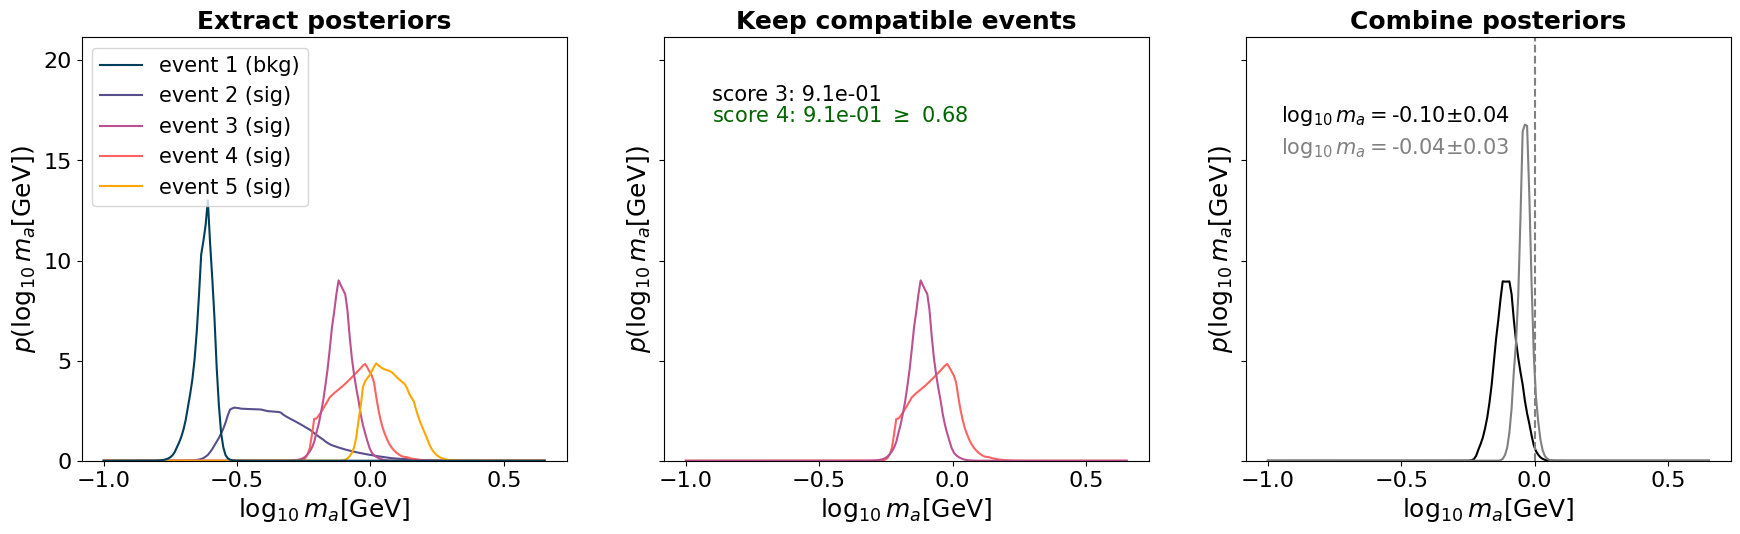

In [81]:
plot_wrong(X, Cij3d, Cij4, jr4)
plt.locator_params(axis='y', nbins=5) # just to have prettier tick labels numbers
#plt.savefig("../figures/figs_examples_"+str(iS)+".pdf",bbox_inches='tight')
plt.show()

##### Coverage and sigma distribution when rejecting events

In [82]:
mrange = np.linspace(np.log10(malp_min), np.log10(malp_max), 200)

id_sig = np.sum((scores_final)[:nsig]>0,axis=0) # how many signal events accepted
id_bkg = np.sum((scores_final)[nsig:]>0,axis=0) # how many bkg events accepted

In [83]:
def post_prod(x):
    xprod =  np.prod(np.exp(x),axis=1)
    norms = trapezoid(xprod, mrange.reshape(1,-1))
    xprod = xprod/norms.reshape(-1,1)
    return xprod

In [84]:
# indeces of signal events
range_sig = list(range(nsig))

In [85]:
# could be automated, but for now fine
X0 = post_prod(X[(id_bkg==0)*(id_sig==nsig),:nsig,:])
X0 = np.array(X0)

In [86]:
# remove 1st discarded signal event
X1_list = []
for isig in range(nsig):
    range_temp = range_sig.copy()
    range_temp.remove(isig)
    X1_temp = post_prod(X[(id_bkg==0)*(id_sig==nsig-1)*(scores_final[isig]==0)][:,range_temp,:])
    X1_list.append(np.array(X1_temp))
    print(range_temp)
X1 = np.vstack((X1_list))


[1, 2, 3]
[0, 2, 3]
[0, 1, 3]
[0, 1, 2]


In [87]:
# remove first two discarded signal events
X2_list = []
for isig1 in range(nsig):
    for isig2 in range(isig1+1, nsig):
        range_temp = range_sig.copy()
        range_temp.remove(isig1)
        range_temp.remove(isig2)
        X2_temp = post_prod(X[(id_bkg==0)*(id_sig==nsig-2)*(scores_final[isig1]==0)*(scores_final[isig2]==0)][:,range_temp,:])
        X2_list.append(np.array(X2_temp))
        print(range_temp)
X2 = np.vstack((X2_list))


[2, 3]
[1, 3]
[1, 2]
[0, 3]
[0, 2]
[0, 1]


In [88]:
# mass prediction and its uncertainty
def mass_sig(X): 
    meanmass= (trapezoid(mrange*X, mrange.reshape(1,-1)))
    sigs = (np.sqrt(trapezoid((mrange**2)*X, mrange.reshape(1,-1))-trapezoid(mrange*X, mrange.reshape(1,-1))**2))
    return meanmass, sigs

In [89]:
meanmass0, sigs0 = mass_sig(X0)
meanmass1, sigs1 = mass_sig(X1)
meanmass2, sigs2 = mass_sig(X2)

In [90]:
ibin = np.digitize(np.log10(mfixed), mrange)
def comp_clevel(X):
    clevel = []
    for iS in range(len(X)):
        posts= X[iS]
        clevel.append(trapezoid(posts[posts>(posts[ibin-1]+posts[ibin])/2], mrange.reshape(-1,1)[posts>(posts[ibin-1]+posts[ibin])/2].T))
    clevel = np.array(clevel)
    return clevel

In [91]:
# confidence levels for the coverage tests
clevel0 = comp_clevel(X0)
clevel1 = comp_clevel(X1)
clevel2 = comp_clevel(X2)

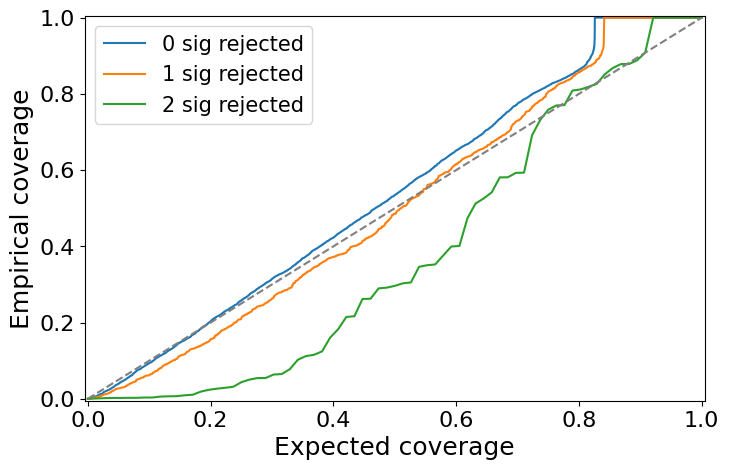

In [92]:
fig,ax = plt.subplots(figsize=(figwidth/2,5))
ax.plot(np.linspace(0,1, len(clevel0)), np.sort(1-clevel0.flatten()), linewidth=1.5, label="0 sig rejected")
ax.plot(np.linspace(0,1, len(clevel1)), np.sort(1-clevel1.flatten()), linewidth=1.5, label="1 sig rejected")
ax.plot(np.linspace(0,1, len(clevel2)), np.sort(1-clevel2.flatten()), linewidth=1.5, label="2 sig rejected")


plt.plot(np.linspace(0,1, 10000), np.linspace(0,1, 10000), color='grey', linestyle='--')
plt.xlim(-0.005, 1.005)
plt.ylim(-0.005, 1.005)
plt.legend(fontsize=le_size)
ax.tick_params(axis='both', which='major', labelsize=majt_size)
ax.tick_params(axis='both', which='minor', labelsize=mint_size)
plt.xlabel("Expected coverage", fontsize=la_size)
plt.ylabel("Empirical coverage", fontsize=la_size)
# plt.savefig("../figures/coverage_sig.pdf", bbox_inches='tight')
plt.show()